# Validating the New Filter Parameters in the Tesla

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import fetch_data
import numpy as np
import correct_drift
import datetime
from scipy import signal
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick
from ahrs.filters import Mahony

import importlib
importlib.reload(fetch_data)

<module 'fetch_data' from '/home/tyler/Documents/Matt3r/IMU_validation/fetch_data.py'>

Select Data

In [41]:
# Hamid data
start_date_str = '2023-06-27'
end_date_str = '2023-06-27'
organization_id = 'hamid'
can_k3y_id = '17700cf8'
imu_k3y_id = '17700cf8'

In [8]:
# Amir M data
start_date_str = '2023-06-27'
end_date_str = '2023-06-27'
organization_id = 'amirm'
can_k3y_id = 'c9a6b512'
imu_k3y_id = 'c9a6b512'

Get the CAN Server Data

In [42]:
event_dict = fetch_data.get_events(can_k3y_id, organization_id, start_date_str, end_date_str)
can_df = fetch_data.get_can_data(can_k3y_id, organization_id, start_date_str, end_date_str)

Get the IMU Data

In [43]:
# use if we have clock data
imu_df = fetch_data.get_imu_data(imu_k3y_id, organization_id, start_date_str, end_date_str)

In [10]:
# use if no clock data available
start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')
imu_df = correct_drift.fetch_imu_data(imu_k3y_id, organization_id, start_date, end_date)

Correct the Rotation Matrix for Hamid's Data

In [44]:
GLOVE_TO_CONSOLE_MTX = np.array([[0, 0, 1], [0.0856, 0.9963, 0], [-0.9963, 0.0856, 0]])
S3_K3Y_VEH_ROT_MTX_CONSOLE = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
S3_K3Y_VEH_ROT_MTX = np.matmul(S3_K3Y_VEH_ROT_MTX_CONSOLE, GLOVE_TO_CONSOLE_MTX)
CORRECTION_MATRIX = S3_K3Y_VEH_ROT_MTX_CONSOLE@np.linalg.inv(S3_K3Y_VEH_ROT_MTX)

if organization_id == 'hamid':
    acc_np = imu_df[['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)']].to_numpy()
    vehicle_ac = np.matmul(CORRECTION_MATRIX, acc_np[:, 1:].T)
    vehicle_ac_np = np.column_stack((acc_np[:,0], vehicle_ac.T))
    imu_df = pd.DataFrame(vehicle_ac_np, columns=['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)'])

Filter Out Warmup Time

In [50]:
warmup_start = 1687886372
warmup_end = 1687886435
imu_df = imu_df[(imu_df['correct_timestamp'] <= warmup_start) | (imu_df['correct_timestamp'] >= warmup_end)]

Get Stationary State Data Metrics

In [51]:
# stitching together all stationary state data
imu_ss_states = []
can_ss_states = []
for state_num in range(len(event_dict['stationary_state'])):
    ss_start_time = event_dict['stationary_state'][state_num]['start']
    ss_end_time = event_dict['stationary_state'][state_num]['end']
    imu_ss_states.append(imu_df[(imu_df['correct_timestamp'] >= ss_start_time) 
                       & (imu_df['correct_timestamp'] <= ss_end_time)])
    can_ss_states.append(can_df[(can_df['timestamp'] >= ss_start_time) 
                        & (can_df['timestamp'] <= ss_end_time)])
imu_ss_df = pd.concat(imu_ss_states, ignore_index=True)
can_ss_df = pd.concat(can_ss_states, ignore_index=True)

print('left/right acceleration:')
print(f'imu mean: {imu_ss_df["lr_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["lr_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["lr_acc(m/s^2)"].min()}')
print(f'can mean: {can_ss_df["lr_acc"].mean()}')
print(f'can max: {can_ss_df["lr_acc"].max()}')
print(f'can min: {can_ss_df["lr_acc"].min()}')
print('')
print('back/from acceleration:')
print(f'imu mean: {imu_ss_df["bf_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["bf_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["bf_acc(m/s^2)"].min()}')
print(f'can mean: {can_ss_df["bf_acc"].mean()}')
print(f'can max: {can_ss_df["bf_acc"].max()}')
print(f'can min: {can_ss_df["bf_acc"].min()}')
print('')
print('vertical acceleration:')
print(f'imu mean: {imu_ss_df["vert_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["vert_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["vert_acc(m/s^2)"].min()}')
print(f'can mean: {can_ss_df["vert_acc"].mean()}')
print(f'can max: {can_ss_df["vert_acc"].max()}')
print(f'can min: {can_ss_df["vert_acc"].min()}')
print('')
print('normalized acceleration:')
imu_norm = np.sqrt(imu_ss_df['lr_acc(m/s^2)']**2 + imu_ss_df['bf_acc(m/s^2)']**2 + imu_ss_df['vert_acc(m/s^2)']**2)
can_norm = np.sqrt(can_ss_df['lr_acc']**2 + can_ss_df['bf_acc']**2 + can_ss_df['vert_acc']**2)
print(f'imu mean: {imu_norm.mean()}')
print(f'imu max: {imu_norm.max()}')
print(f'imu min: {imu_norm.min()}')
print(f'can mean: {can_norm.mean()}')
print(f'can max: {can_norm.max()}')
print(f'can min: {can_norm.min()}')

left/right acceleration:
imu mean: 0.0010384457982070686
imu max: 0.04197841934179192
imu min: -0.03665230925106546
can mean: -0.1552955459969474
can max: 37.12
can min: -38.40125

back/from acceleration:
imu mean: -0.01170462809336089
imu max: 0.06921509306840355
imu min: -0.08512179693159638
can mean: 0.1627731719161926
can max: 26.55875
can min: -37.78875

vertical acceleration:
imu mean: 0.07495537943618832
imu max: 0.13921002665947668
imu min: 0.020167231659476315
can mean: 0.04204297904814764
can max: 28.48
can min: -37.12125

normalized acceleration:
imu mean: 0.0769047733714147
imu max: 0.14308900370244915
imu min: 0.024697286258345212
can mean: 0.40049774718598147
can max: 63.4239010793644
can min: 0.20461091124375552


Plot Stationary States

In [ ]:
# plotting the IMU stationary state accelerations
edge_time = 10

for state_num in range(len(event_dict['stationary_state'])):
    ss_start_time = event_dict['stationary_state'][state_num]['start']
    ss_end_time = event_dict['stationary_state'][state_num]['end']
    ss_motion = imu_df[(imu_df['correct_timestamp'] >= ss_start_time - edge_time) 
                       & (imu_df['correct_timestamp'] <= ss_end_time + edge_time)]
    can_motion = can_df[(can_df['timestamp'] >= ss_start_time - edge_time) 
                        & (can_df['timestamp'] <= ss_end_time + edge_time)]

    if (len(ss_motion) != 0):
        print(f'CAN time is {can_motion["timestamp"].iloc[0]}')
        print(f'IMU raw time is {ss_motion["correct_timestamp"].iloc[0]}')
        print(f'Delta is {can_motion["timestamp"].iloc[0] - ss_motion["correct_timestamp"].iloc[0]}')
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

        fig.set_size_inches(10,6)

        lr_mean = ss_motion['lr_acc(m/s^2)'].mean()
        bf_mean = ss_motion['bf_acc(m/s^2)'].mean()
        vert_mean = ss_motion['vert_acc(m/s^2)'].mean()
        lr_can_mean = can_motion['lr_acc'].mean()
        bf_can_mean = can_motion['bf_acc'].mean()
        vert_can_mean = can_motion['vert_acc'].mean()

        ax1.scatter(x=can_motion['timestamp'] - ss_start_time, y=can_motion['lr_acc'], s=1, color='red', label='CANserver')
        ax1.scatter(x=ss_motion['correct_timestamp'] - ss_start_time, y=-ss_motion['lr_acc(m/s^2)'], s=1, label='IMU')
        ax1.set_ylim(-15,15)

        ax2.scatter(x=can_motion['timestamp'] - ss_start_time, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
        ax2.scatter(x=ss_motion['correct_timestamp'] - ss_start_time, y=ss_motion['bf_acc(m/s^2)'], s=1, label='IMU')
        ax2.set_ylim(-15,15)

        ax3.scatter(x=can_motion['timestamp'] - ss_start_time, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
        ax3.scatter(x=ss_motion['correct_timestamp'] - ss_start_time, y=ss_motion['vert_acc(m/s^2)'], s=1, label='IMU')
        ax3.set_ylim(-15,15)

        fig.suptitle("IMU Acceleraion Metrics for Stationary State Data")
        fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

        fig.text(0.08,0.08,f'IMU mean: {lr_mean:.4f}')
        fig.text(0.41,0.08,f'IMU mean: {bf_mean:.4f}')
        fig.text(0.74,0.08,f'IMU mean: {vert_mean:.4f}')
        fig.text(0.08,0.11,f'CAN mean: {lr_can_mean:.4f}')
        fig.text(0.41,0.11,f'CAN mean: {bf_can_mean:.4f}')
        fig.text(0.74,0.11,f'CAN mean: {vert_can_mean:.4f}')

        ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
        ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
        ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

        ax1.legend()
        ax2.legend()
        ax3.legend()
        plt.tight_layout()
        plt.show()

Plot the Driving State Data

11


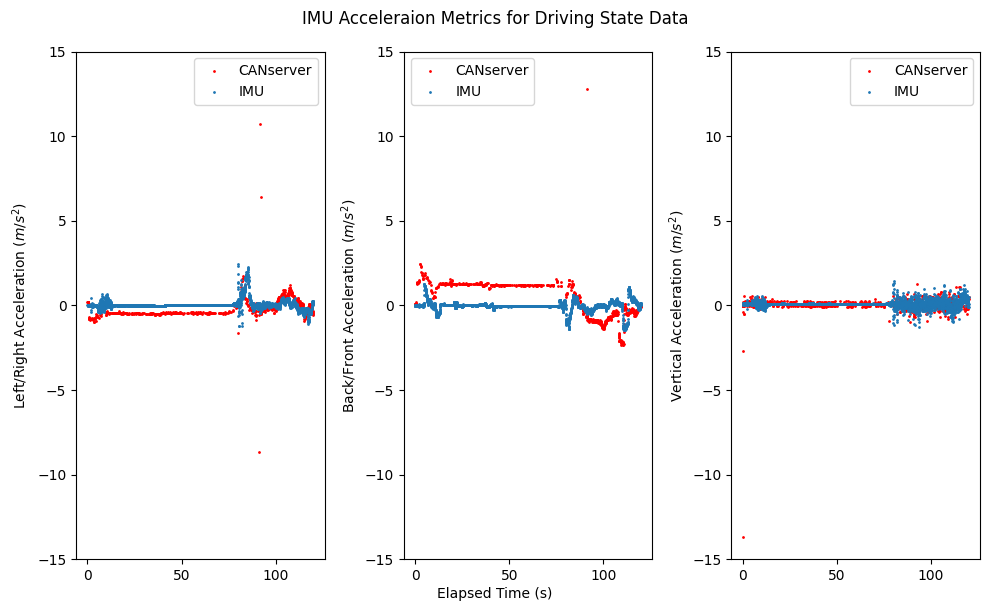

12


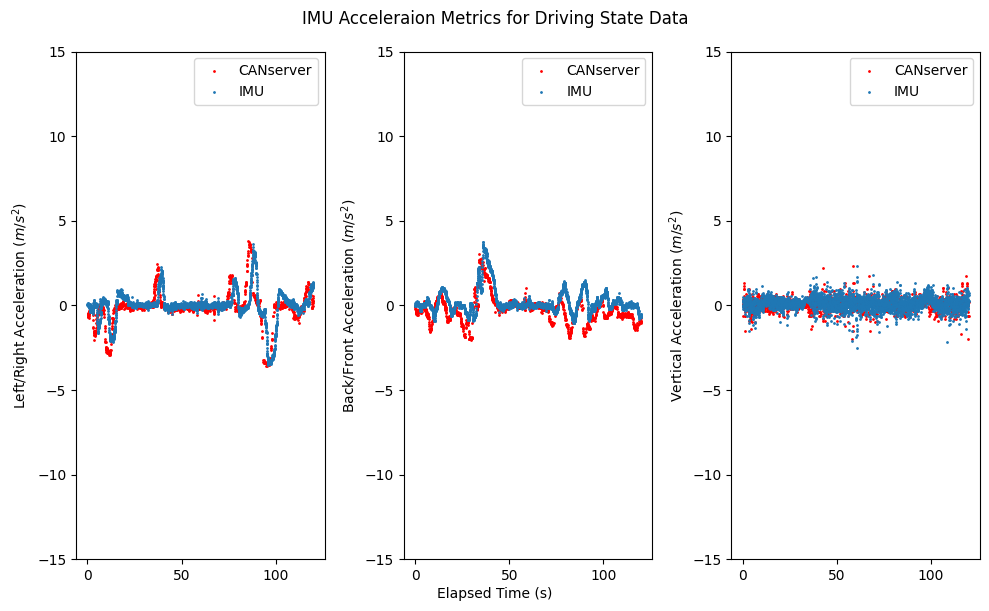

13


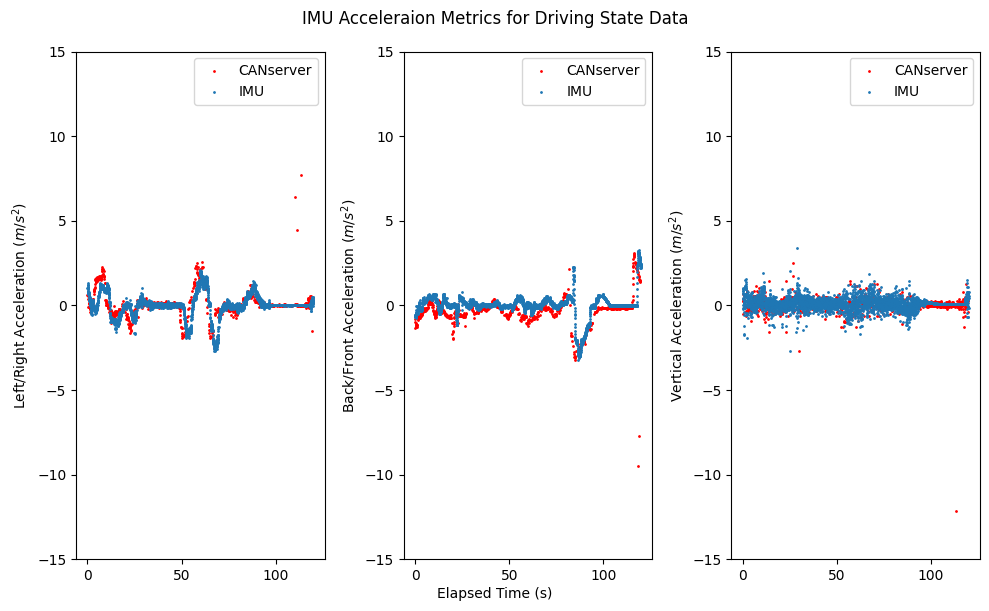

14


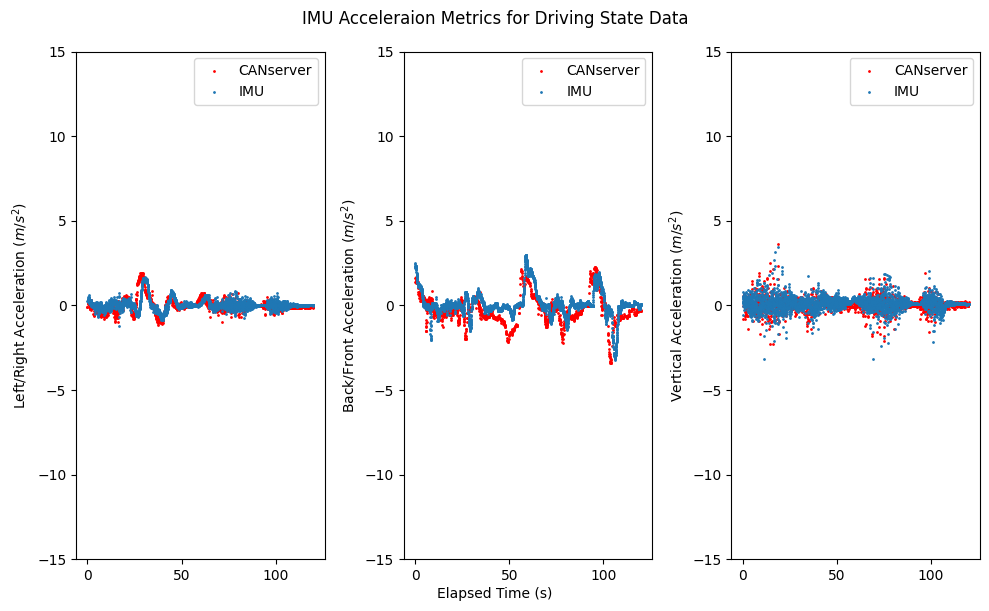

15


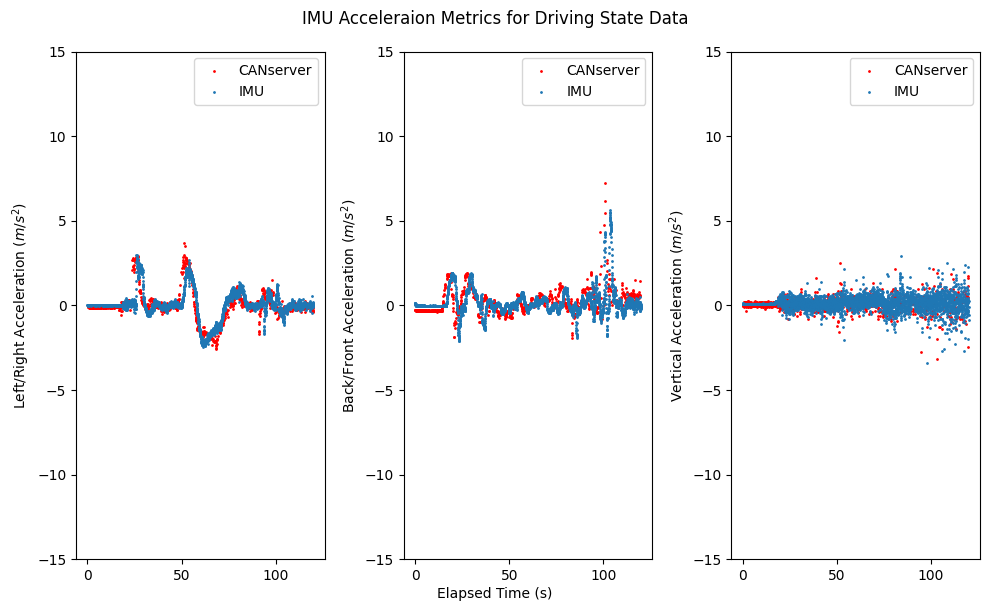

16


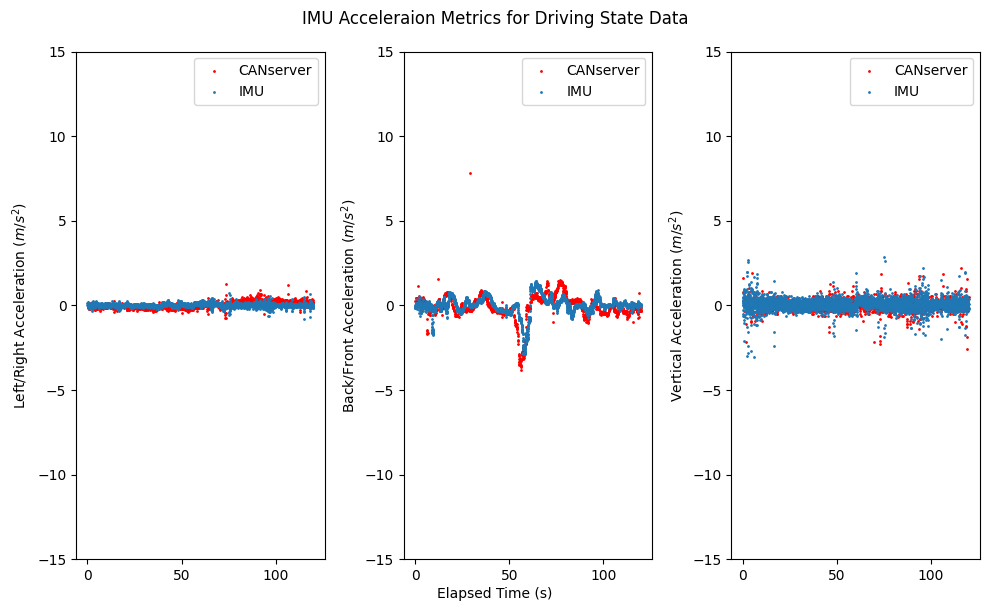

17


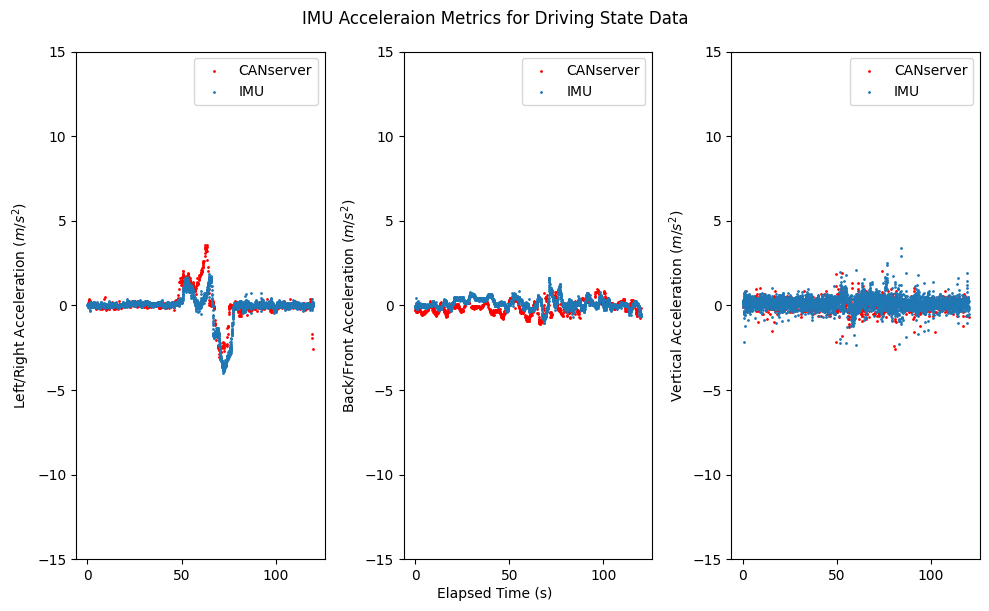

18


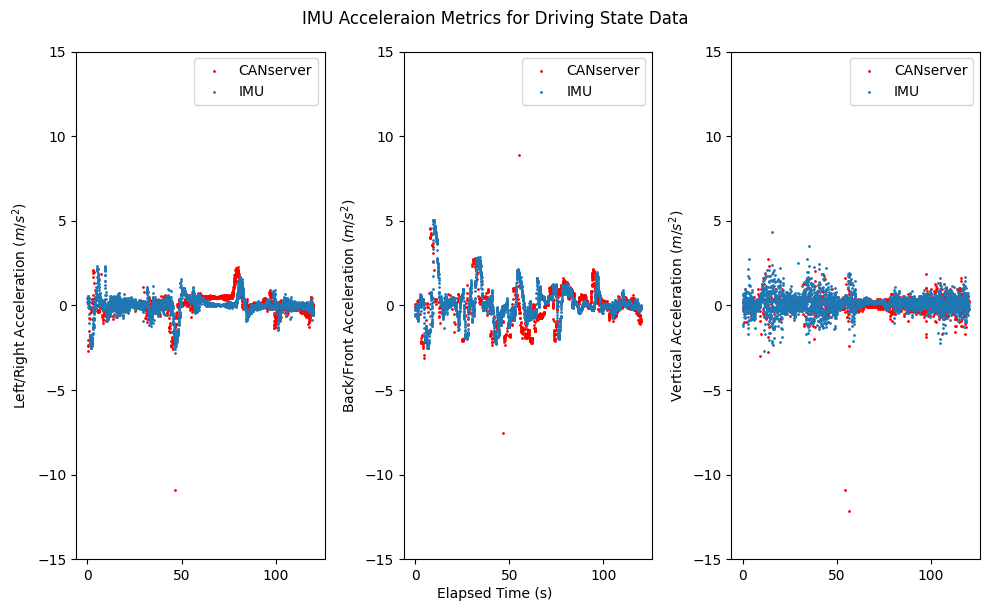

19


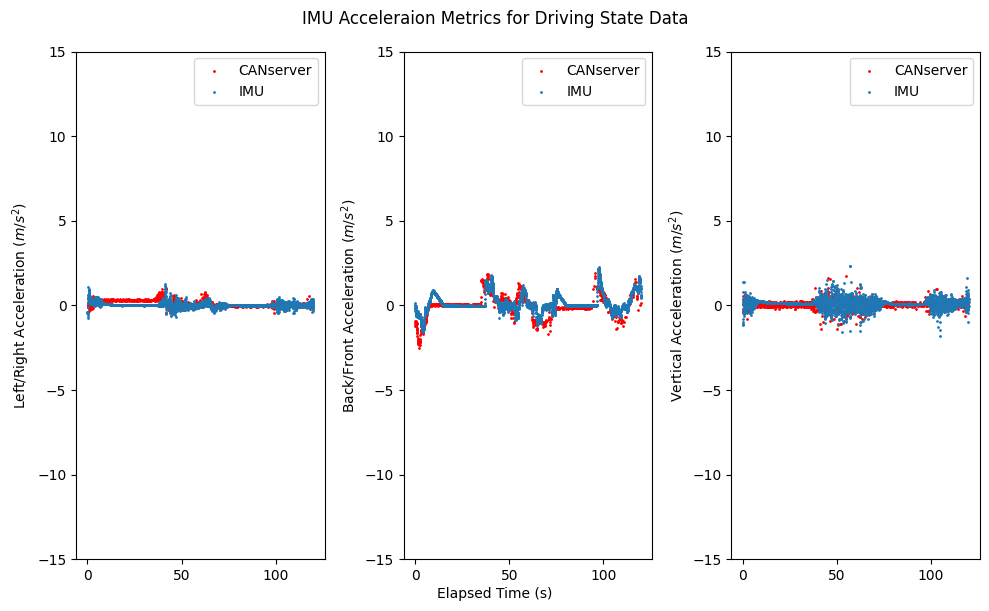

20


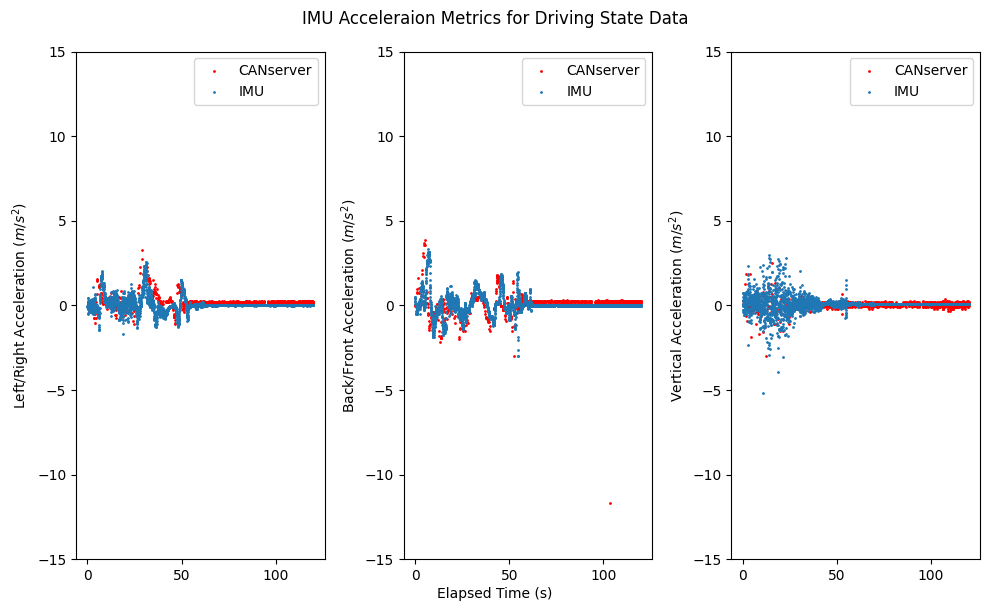

21


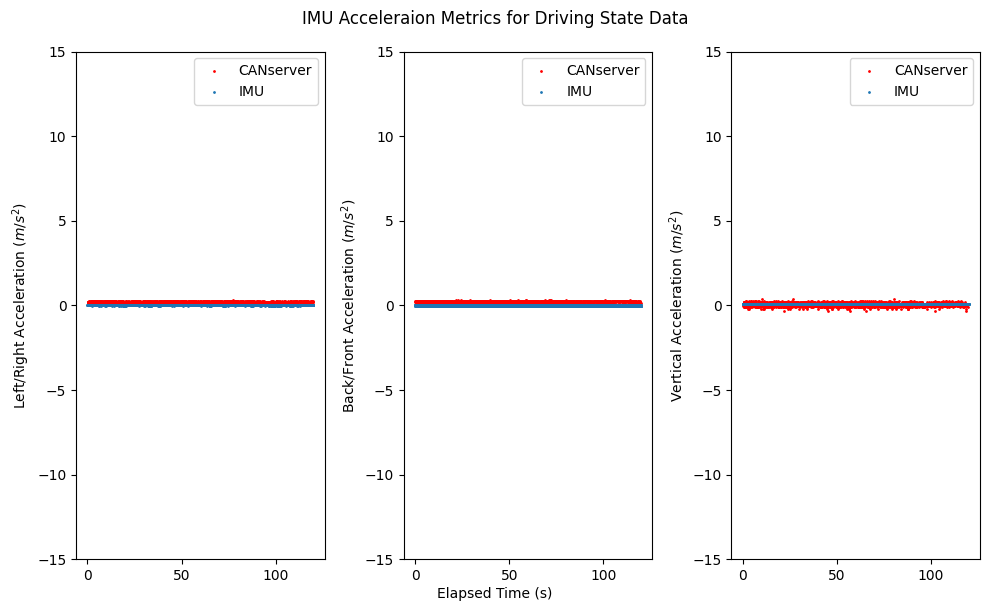

22


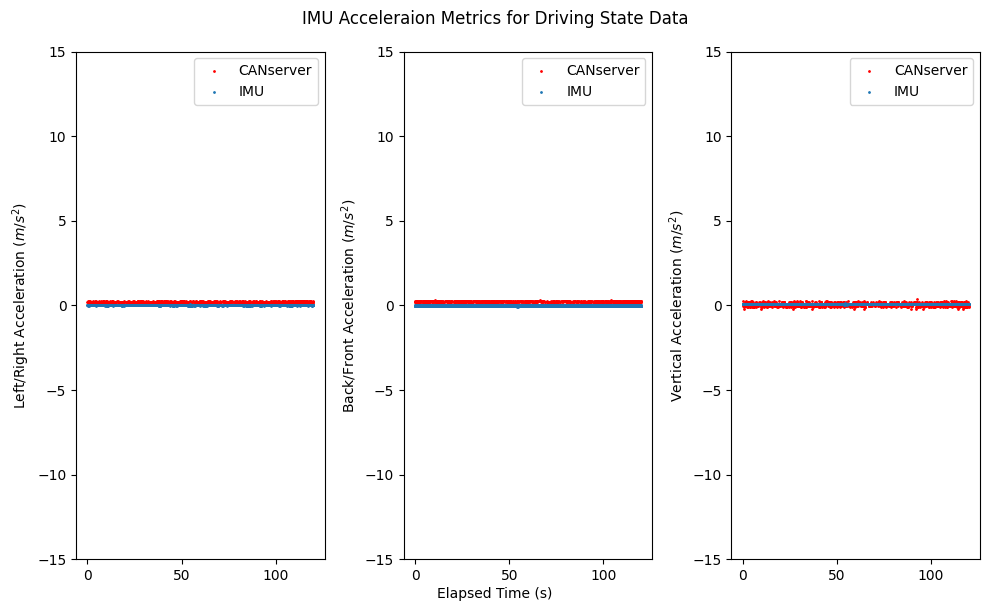

23


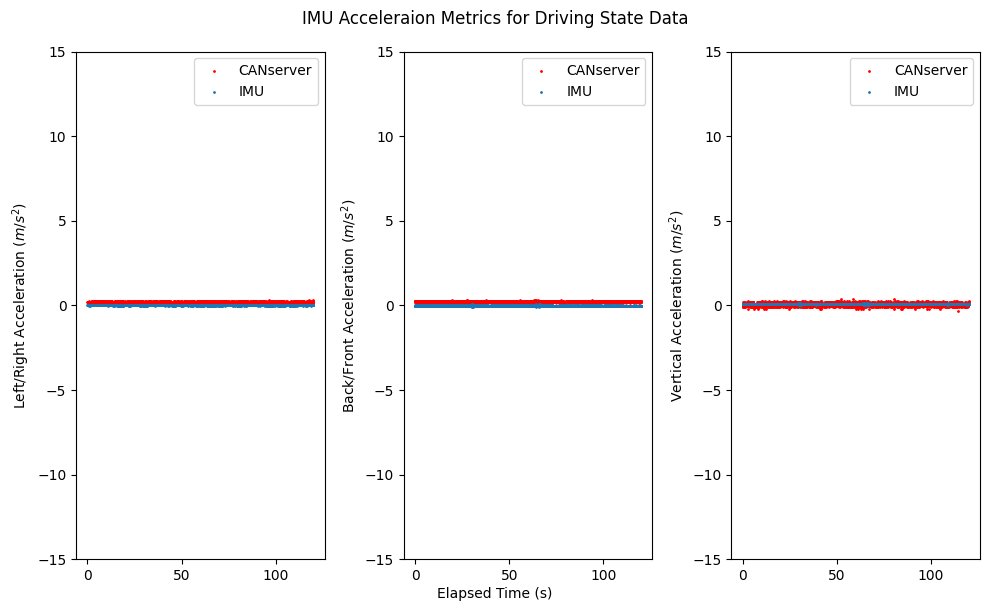

24


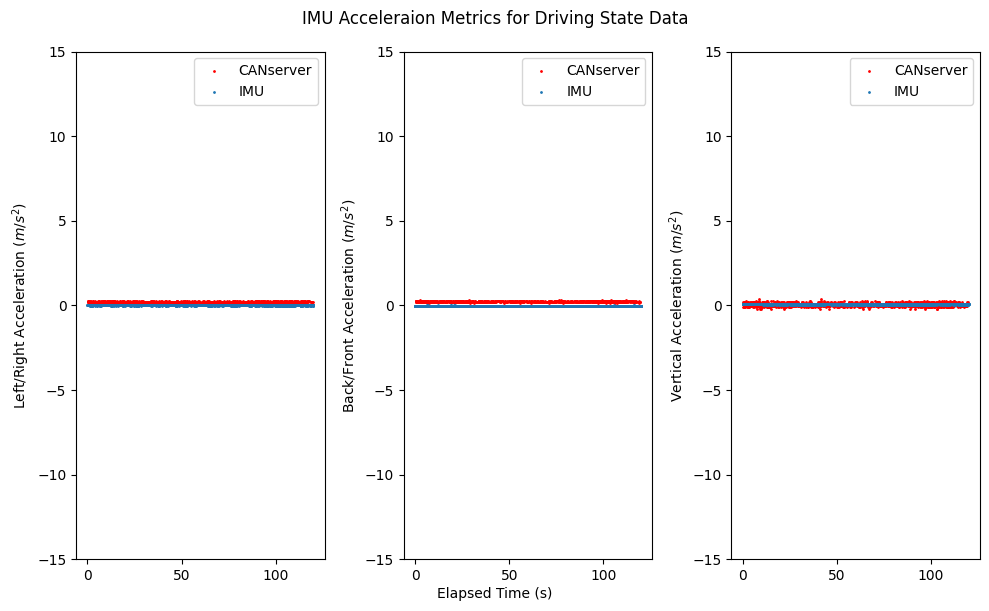

25


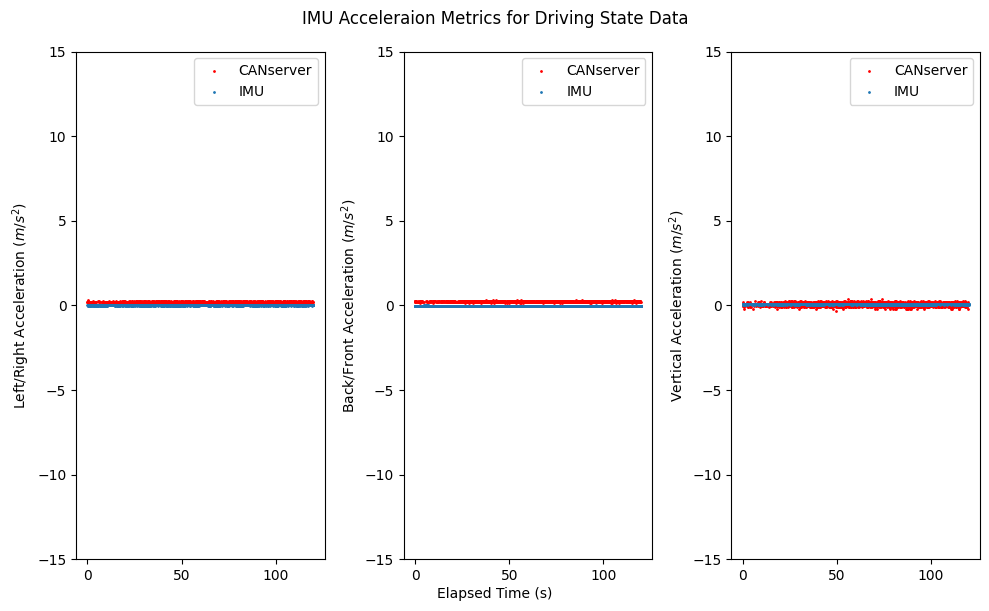

26


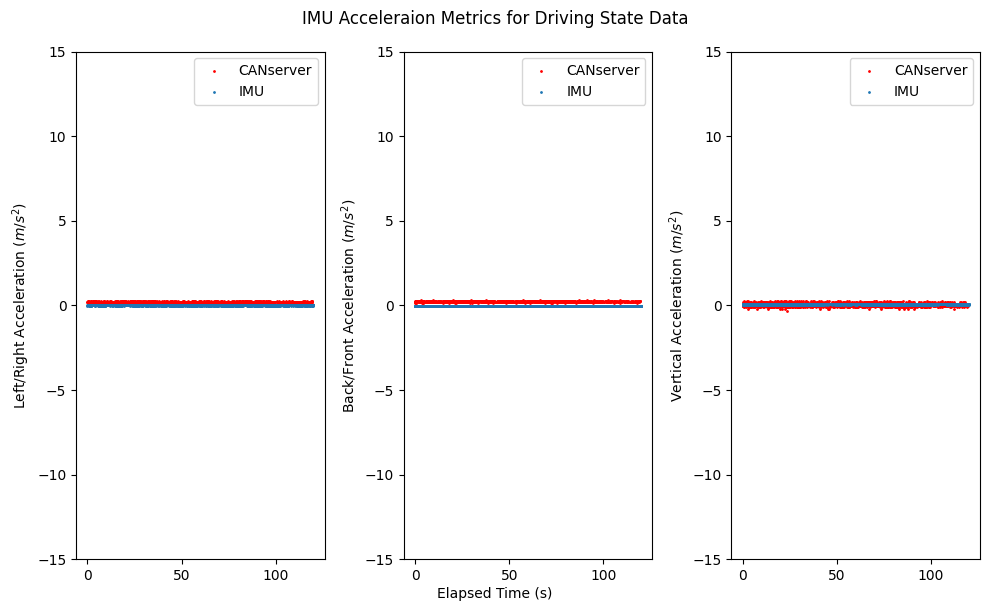

27


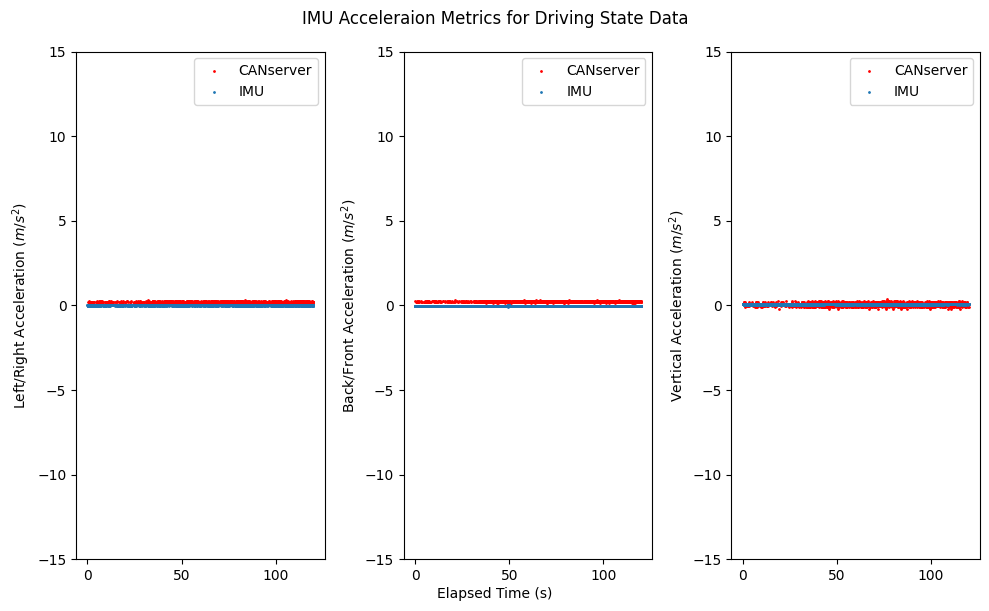

28


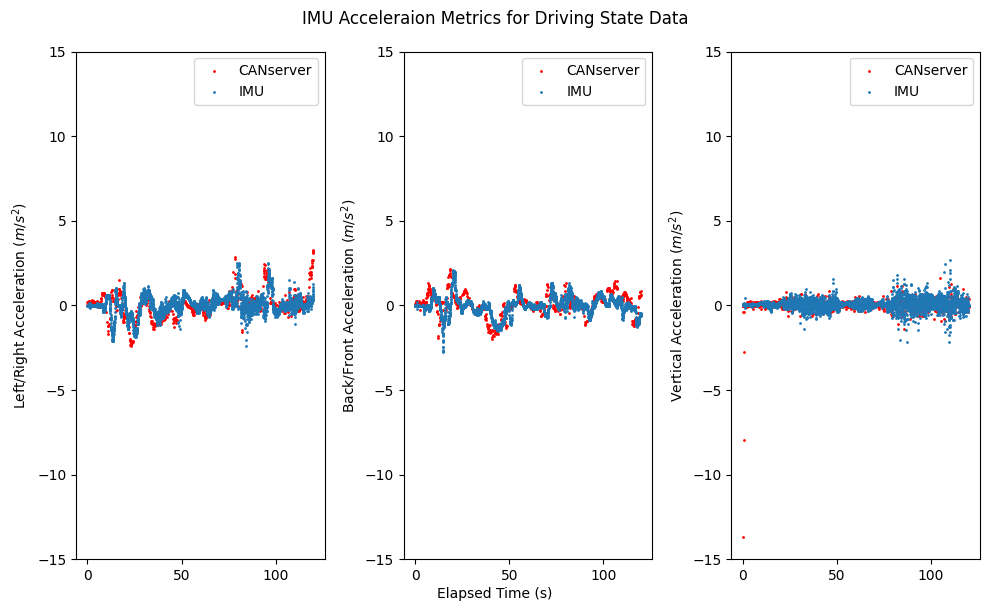

29


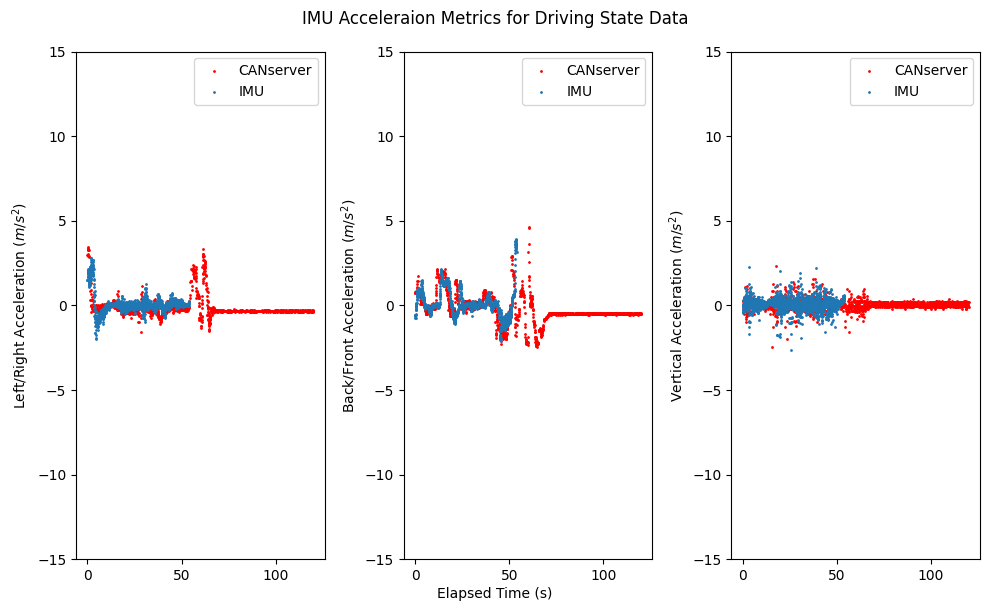

32


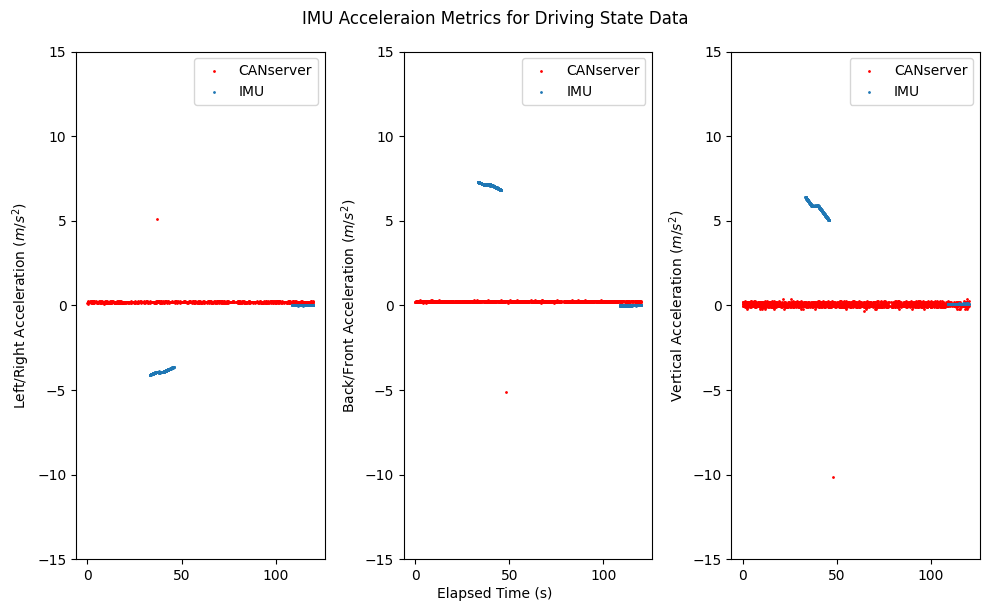

33


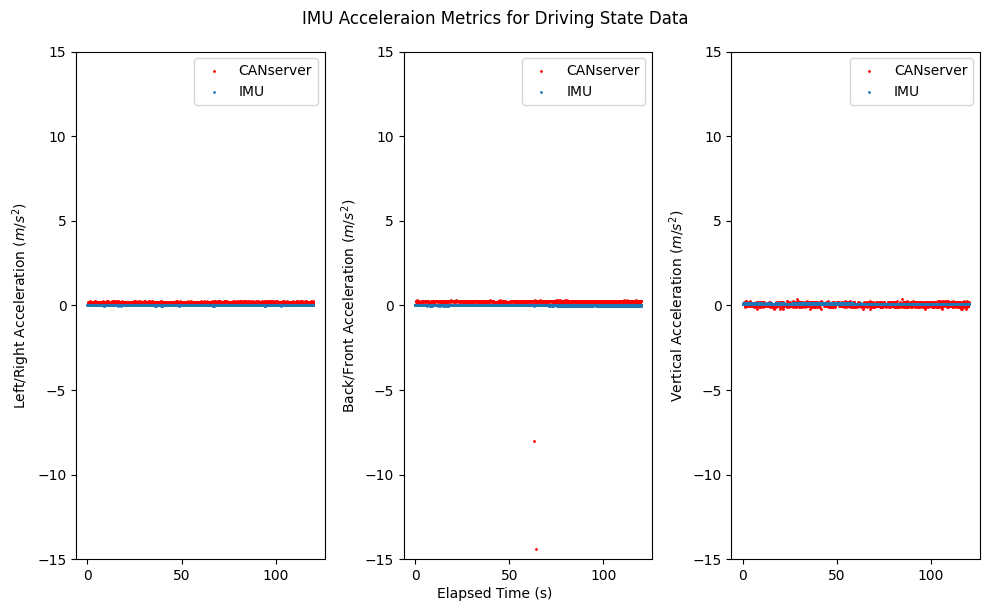

In [58]:
# plot driving state data in intervals of 120 seconds

window = 120
count = 0
can_df = can_df[can_df['bf_acc'].notna()]
can_df.reset_index(drop=True, inplace=True)

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = imu_df[(imu_df['correct_timestamp'] >= dr_start_time) 
                        & (imu_df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        count += 1
        # if ((len(dr_motion) != 0) and (len(can_motion) != 0) and (count < 20)):
        if ((len(dr_motion) != 0) and (len(can_motion) != 0)):
            print(count)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            fig.set_size_inches(10,6)

            lr_mean = dr_motion['lr_acc(m/s^2)'].mean()
            bf_mean = dr_motion['bf_acc(m/s^2)'].mean()
            vert_mean = dr_motion['vert_acc(m/s^2)'].mean()
            lr_can_mean = can_motion['lr_acc'].mean()
            bf_can_mean = can_motion['bf_acc'].mean()
            vert_can_mean = can_motion['vert_acc'].mean()

            ax1.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=-can_motion['lr_acc'], s=1, color='red', label='CANserver')
            ax1.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['lr_acc(m/s^2)'], s=1, label='IMU')
            ax1.set_ylim(-15,15)

            ax2.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
            ax2.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['bf_acc(m/s^2)'], s=1, label='IMU')
            ax2.set_ylim(-15,15)

            ax3.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
            ax3.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['vert_acc(m/s^2)'], s=1, label='IMU')
            ax3.set_ylim(-15,15)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
            ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
            ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.tight_layout()
            plt.show()

Scratch Work

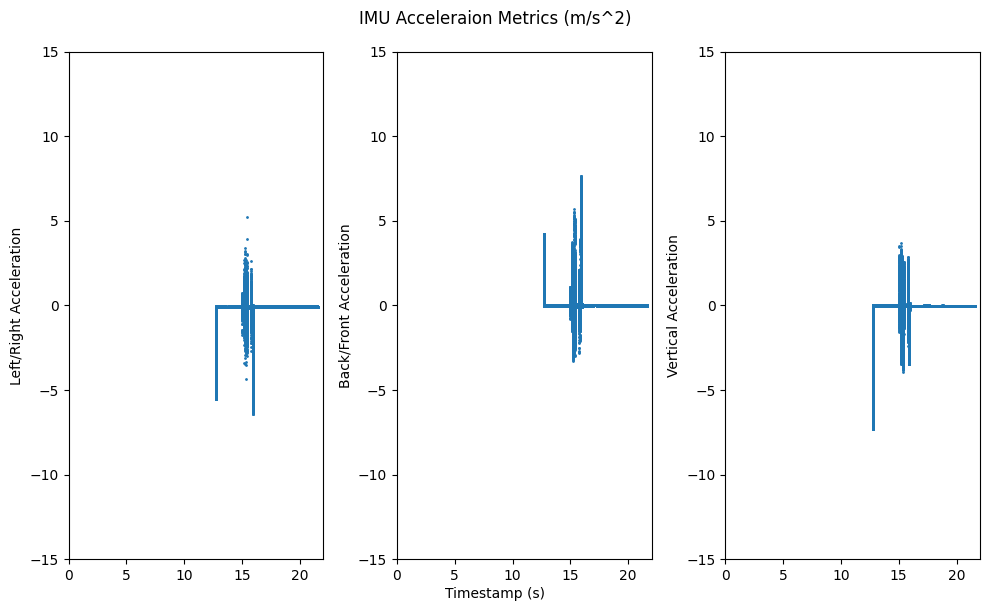

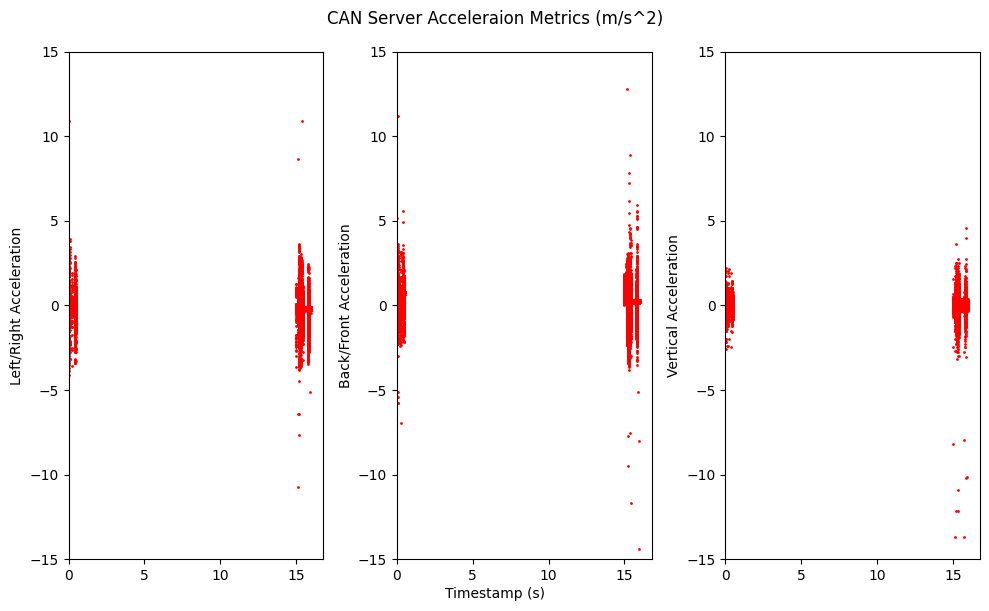

In [17]:
# plot all data

imu_df['timestamp(epoch in sec)'] = pd.to_numeric(imu_df['timestamp(epoch in sec)'], errors='coerce')
imu_df.dropna(inplace=True)
imu_df.reset_index(drop=True, inplace=True)

# plot the IMU data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
start_time = min(imu_df['timestamp(epoch in sec)'].min(), can_df['timestamp'].min())

fig.set_size_inches(10,6)
ax1.scatter(x=(imu_df['timestamp(epoch in sec)'] - start_time)/3600, y=imu_df['lr_acc(m/s^2)'], s=1, label='IMU')
ax1.set_ylim(-15,15)
ax1.set_xlim(left=0)
ax2.scatter(x=(imu_df['timestamp(epoch in sec)'] - start_time)/3600, y=imu_df['bf_acc(m/s^2)'], s=1, label='IMU')
ax2.set_ylim(-15,15)
ax2.set_xlim(left=0)
ax3.scatter(x=(imu_df['timestamp(epoch in sec)'] - start_time)/3600, y=imu_df['vert_acc(m/s^2)'], s=1, label='IMU')
ax3.set_ylim(-15,15)
ax3.set_xlim(left=0)

fig.set_size_inches(10,6)
ax1.scatter(x=(imu_df['timestamp(epoch in sec)'])/3600, y=imu_df['lr_acc(m/s^2)'], s=1, label='IMU')
ax1.set_ylim(-15,15)
ax1.set_xlim(left=0)
ax2.scatter(x=(imu_df['timestamp(epoch in sec)'])/3600, y=imu_df['bf_acc(m/s^2)'], s=1, label='IMU')
ax2.set_ylim(-15,15)
ax2.set_xlim(left=0)
ax3.scatter(x=(imu_df['timestamp(epoch in sec)'])/3600, y=imu_df['vert_acc(m/s^2)'], s=1, label='IMU')
ax3.set_ylim(-15,15)
ax3.set_xlim(left=0)

fig.suptitle("IMU Acceleraion Metrics (m/s^2)")
fig.text(0.5, 0.0, 'Timestamp (s)', ha='center')

ax1.set_ylabel("Left/Right Acceleration")
ax2.set_ylabel("Back/Front Acceleration")
ax3.set_ylabel("Vertical Acceleration")

plt.tight_layout()
plt.show()

# plot the CAN Server data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(10,6)
ax1.scatter(x=(can_df['timestamp'] - start_time)/3600, y=can_df['lr_acc'], s=1, color='red', label='CANserver')
ax1.set_ylim(-15,15)
ax1.set_xlim(left=0)
ax2.scatter(x=(can_df['timestamp'] - start_time)/3600, y=can_df['bf_acc'], s=1, color='red', label='CANserver')
ax2.set_ylim(-15,15)
ax2.set_xlim(left=0)
ax3.scatter(x=(can_df['timestamp'] - start_time)/3600, y=can_df['vert_acc'], s=1, color='red', label='CANserver')
ax3.set_ylim(-15,15)
ax3.set_xlim(left=0)

fig.suptitle("CAN Server Acceleraion Metrics (m/s^2)")
fig.text(0.5, 0.0, 'Timestamp (s)', ha='center')

ax1.set_ylabel("Left/Right Acceleration")
ax2.set_ylabel("Back/Front Acceleration")
ax3.set_ylabel("Vertical Acceleration")

plt.tight_layout()
plt.show()